In [1]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}') 

In [2]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

# **실습 3 : Inception V3 Model Fine Tuning**

## **Import Module**

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import CSVLogger
import torchvision
import torchvision.transforms as transforms
from torchmetrics import functional as FM
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from IPython import display

device ='cuda:0'
torch.__version__

'1.11.0+cu113'

## **Dataset Load**

In [4]:
from torchvision.datasets.utils import download_and_extract_archive
import pathlib

dataset_url = \
      "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
root = './'  
data_dir='Dataset'    
download_and_extract_archive(dataset_url, root, data_dir)
data_dir = root+data_dir+'/flower_photos/'
data_dir = pathlib.Path(data_dir)
data_dir  

  0%|          | 0/228813984 [00:00<?, ?it/s]

Extracting ./flower_photos.tgz to Dataset


PosixPath('Dataset/flower_photos')

In [5]:
!ls {data_dir}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


##### Check Images

In [6]:
# 지정 폴더 아래에 있는 모든 *.jpg 파일의 수
#  및 폴더명 목록을 리턴  
def check_dir(d_path):
    img_count = len(list(d_path.glob('*/*.jpg')))
    c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
    return img_count, c_name, len(c_name)

# check_dir()로 폴더명과 이미지 숫자 확인
image_count, CLASS_name, class_num = check_dir(data_dir)
CLASS_name.sort()
print('Train image_count: {}\nclasses: {}'.format(image_count, CLASS_name))

Train image_count: 3670
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [7]:
# 지정 path 아래에 있는 폴더에서 이미지 두장씩을 확인
def check_image(d_path, class_list):
    for i in range(len(class_list)):
        class_temp = list(d_path.glob(str(class_list[i])+'/*'))
        for image_path in class_temp[:2]:
            display.display(Image.open(str(image_path)))
# check_image()로 이미지 두장씩 확인 
check_image(data_dir, CLASS_name)

Output hidden; open in https://colab.research.google.com to view.

#### ImageFolder, DataLoader 적용 

In [8]:
# Imagae size 결정 **
IN_IMG_SIZE = 299
batch_n = 32

In [9]:
from torchvision.transforms.autoaugment import AutoAugment
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## loader에 적용할 transform 
_transforms = transforms.Compose([transforms.Resize((IN_IMG_SIZE, IN_IMG_SIZE)),
#                                transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), shear=0.2),
#                                transforms.RandomResizedCrop(IN_IMG_SIZE, scale=[0.2, 1.0]),
                               transforms.RandomHorizontalFlip(0.5),
#                              transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                              transforms.ToTensor()])
## ImageFolder : folder로 구성된 image set을 위한 loader 
imgs = ImageFolder(data_dir, transform=_transforms) #(image,label)

len(imgs) 

3670

##### Train / Test Data split

In [10]:
import torch.utils.data as data

train_set_size = int(len(imgs) * 0.8)
valid_set_size = len(imgs) - train_set_size

# split the train set into two
train_set, valid_set = data.random_split(imgs, [train_set_size, valid_set_size])

print(train_set_size,valid_set_size)  

2936 734


In [11]:
## DataLoader : dataset과 sampler를 결합 batch단위 제공 #(image,label)*batch
train_loader = DataLoader(train_set, batch_size=batch_n, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_n, shuffle=False)

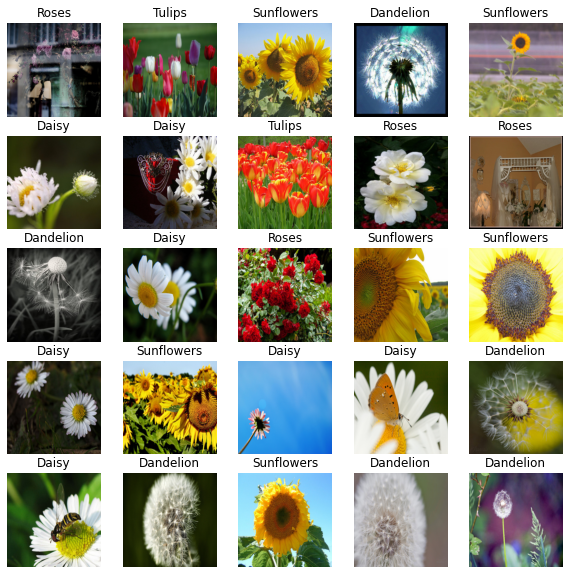

In [12]:
def show_batch(data_gen, class_l):
    # get image and label from data generator
    img_batch, l_batch = next(iter(data_gen))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img_batch[n].permute(1, 2, 0))
        plt.title(class_l[l_batch[n]].title())
        plt.axis('off')
    return img_batch, l_batch

# check dataset
_,_ = show_batch(train_loader, CLASS_name)
#_,_ = show_batch(vla_loader, CLASS_test)

## **Load InceptionV3 model**  
https://pytorch.org/hub/pytorch_vision_inception_v3/ 

In [13]:
InceptionV3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [14]:
input_shape=(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE)
summary(InceptionV3, input_size=input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [32, 1000]                --
├─BasicConv2d: 1-1                       [32, 32, 149, 149]        --
│    └─Conv2d: 2-1                       [32, 32, 149, 149]        864
│    └─BatchNorm2d: 2-2                  [32, 32, 149, 149]        64
├─BasicConv2d: 1-2                       [32, 32, 147, 147]        --
│    └─Conv2d: 2-3                       [32, 32, 147, 147]        9,216
│    └─BatchNorm2d: 2-4                  [32, 32, 147, 147]        64
├─BasicConv2d: 1-3                       [32, 64, 147, 147]        --
│    └─Conv2d: 2-5                       [32, 64, 147, 147]        18,432
│    └─BatchNorm2d: 2-6                  [32, 64, 147, 147]        128
├─MaxPool2d: 1-4                         [32, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [32, 80, 73, 73]          --
│    └─Conv2d: 2-7                       [32, 80, 73, 73]          5,120
│  

In [15]:
InceptionV3 

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [19]:
InceptionV3.fc = nn.Linear(2048, class_num)
InceptionV3  
#summary(InceptionV3, input_shape))  

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [20]:
#torch.onnx.export(InceptionV3, torch.zeros(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE).to(device), 'inceptionV3.onnx')

### **마지막 `Inception module`만 남기고 나머지는 전부 freeze**   
- ### 마지막 conv layer가 fine tuning 됨 


In [21]:
for i, (name,child_module) in enumerate(InceptionV3.named_children()):
  if name == 'Mixed_7c':
    break 
  else : 
    print(i,':',name,'freezed')
    for param in child_module.parameters():
            param.requires_grad = False   

0 : Conv2d_1a_3x3 freezed
1 : Conv2d_2a_3x3 freezed
2 : Conv2d_2b_3x3 freezed
3 : maxpool1 freezed
4 : Conv2d_3b_1x1 freezed
5 : Conv2d_4a_3x3 freezed
6 : maxpool2 freezed
7 : Mixed_5b freezed
8 : Mixed_5c freezed
9 : Mixed_5d freezed
10 : Mixed_6a freezed
11 : Mixed_6b freezed
12 : Mixed_6c freezed
13 : Mixed_6d freezed
14 : Mixed_6e freezed
15 : AuxLogits freezed
16 : Mixed_7a freezed
17 : Mixed_7b freezed


In [22]:
for child in InceptionV3.children():
    for param in child.parameters():
        print(child.__class__, param.requires_grad)  

<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.InceptionA'> False
<class 'torchvision.models.inception.InceptionA'> False
<class 'torchvision.models.incept

## FineTune Model

In [23]:
import torchvision.models as models
import pdb

loss_function = nn.CrossEntropyLoss()

class InceptionFineTune(LightningModule):
    def __init__(self, inceptionv3):
        super(InceptionFineTune, self).__init__()
        self.features = inceptionv3 

    def forward(self, x):
        x = self.features(x)
        return x 

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        # InceptionOutputs은 결과 tensor값을 logits이란 변수로 가짐
        loss = loss_function(y_pred.logits, y)
        acc = FM.accuracy(y_pred.logits, y)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics) 
        return loss
    
    def configure_optimizers(self):

        return torch.optim.Adam(self.parameters(), lr=0.001)

inceptionFineTune = InceptionFineTune(InceptionV3)
summary(inceptionFineTune, input_size=(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
InceptionFineTune                        [32, 5]                   --
├─Inception3: 1-1                        [32, 5]                   --
│    └─BasicConv2d: 2-1                  [32, 32, 149, 149]        --
│    │    └─Conv2d: 3-1                  [32, 32, 149, 149]        (864)
│    │    └─BatchNorm2d: 3-2             [32, 32, 149, 149]        (64)
│    └─BasicConv2d: 2-2                  [32, 32, 147, 147]        --
│    │    └─Conv2d: 3-3                  [32, 32, 147, 147]        (9,216)
│    │    └─BatchNorm2d: 3-4             [32, 32, 147, 147]        (64)
│    └─BasicConv2d: 2-3                  [32, 64, 147, 147]        --
│    │    └─Conv2d: 3-5                  [32, 64, 147, 147]        (18,432)
│    │    └─BatchNorm2d: 3-6             [32, 64, 147, 147]        (128)
│    └─MaxPool2d: 2-4                    [32, 64, 73, 73]          --
│    └─BasicConv2d: 2-5                  [32, 80, 73, 73]       

In [24]:
from pytorch_lightning.callbacks import ModelSummary

trainer = Trainer(max_epochs=1,callbacks=[ModelSummary(max_depth=2)],accelerator='auto')
trainer.fit(inceptionFineTune, train_loader, val_dataloaders=val_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                   | Type              | Params
--------------------------------------------------------------
0  | features               | Inception3        | 25.1 M
1  | features.Conv2d_1a_3x3 | BasicConv2d       | 928   
2  | features.Conv2d_2a_3x3 | BasicConv2d       | 9.3 K 
3  | features.Conv2d_2b_3x3 | BasicConv2d       | 18.6 K
4  | features.maxpool1      | MaxPool2d         | 0     
5  | features.Conv2d_3b_1x1 | BasicConv2d       | 5.3 K 
6  | features.Conv2d_4a_3x3 | BasicConv2d       | 138 K 
7  | features.maxpool2      | MaxPool2d         | 0     
8  | feature

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## **Fit**

In [25]:
%%time
inceptionFineTune = InceptionFineTune(InceptionV3)

epochs=5
logger = CSVLogger("logs", name="InceptionFineTune")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(inceptionFineTune, train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/InceptionFineTune
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | features | Inception3 | 25.1 M
----------------------------------------
6.1 M     Trainable params
19.0 M    Non-trainable params
25.1 M    Total params
100.490   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CPU times: user 2min 20s, sys: 4.03 s, total: 2min 24s
Wall time: 2min 28s


Epoch 4: 100%  
115/115 [00:33<00:00, 3.47it/s, loss=0.0201, v_num=1]  
CPU times: user 2min 41s, sys: 7.07 s, total: 2min 48s  
Wall time: 2min 54s  

Epoch 9: 100%  
29/29 [00:30<00:00, 1.05s/it, loss=0.0762, v_num=2]  
CPU times: user 5min 3s, sys: 7.23 s, total: 5min 10s  
Wall time: 5min 14s  

Epoch 14: 100%  
29/29 [00:30<00:00, 1.04s/it, loss=0.000898, v_num=2]
CPU times: user 7min 23s, sys: 16.1 s, total: 7min 39s  
Wall time: 7min 39s

## **Analysis**

In [ ]:
v_num = inceptionFineTune.get_progress_bar_dict()['v_num']

history = pd.read_csv(f'./logs/InceptionFineTune/version_{v_num}/metrics.csv')
history_plot = history.drop('step', axis=1).groupby('epoch').last()
print('\t',np.max(history_plot['val_acc']))

	 0.9509536623954772


	 0.9509536623954772


In [ ]:
history_plot

,loss,acc,val_loss,val_acc
epoch,,,,
0,0.142105,0.9375,0.224745,0.937330
1,0.016030,1.0000,0.242918,0.937330
2,0.008503,1.0000,0.241604,0.933242
3,0.008212,1.0000,0.203640,0.950954
4,0.026865,1.0000,0.256767,0.929155


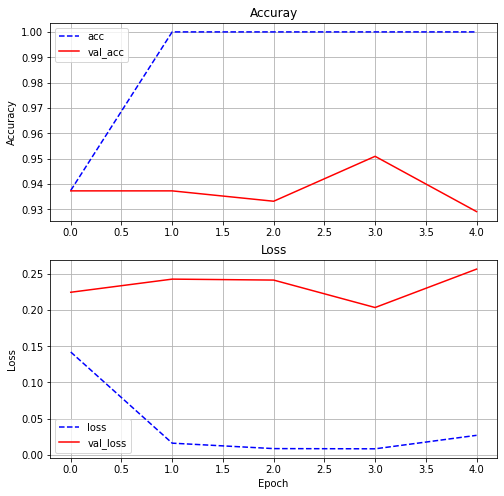

In [ ]:
def plot_history1(history):
#    epochs = range(1, len(history['loss'])+1)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.title('Accuray')
    plt.plot(history['acc'], 'b--', label='acc')
    plt.plot(history['val_acc'], 'r', label='val_acc')
    plt.grid(True)
    plt.ylabel('Accuracy')
    #  plt.ylim([0.8, 1])
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Loss')
    plt.plot(history['loss'], 'b--', label='loss')
    plt.plot(history['val_loss'], 'r', label='val_loss')
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.ylim([0.0, 0.6])
    plt.legend(loc='best')
    plt.show()

plot_history1(history_plot)

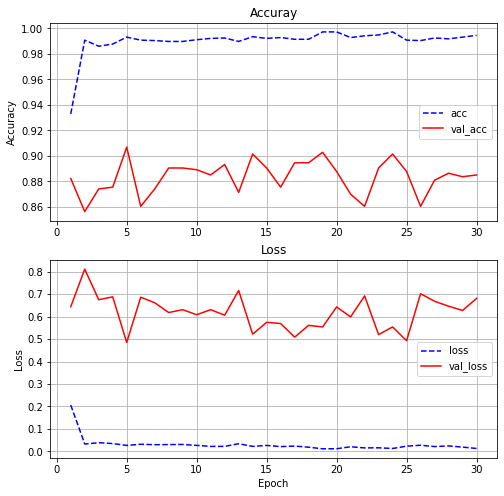

## **실습 과제**

### **마지막 inception module을 학습하도록 남겨놓을 필요가 있을까?**
#### -- 마지막까지 freeze한 경우에 성능은 어떨까 학인해 보자 
#### -- 모델전체를 freeze하지 않고 학습시키면 어떤 결과를 얻을 수 있를까 확인해 보자  


In [ ]:
## 문제점 빠르게 확인하기 
trainer = Trainer(max_epochs=3, 
                  limit_train_batches=0.1, 
                  limit_val_batches=0.2, accelerator='auto')
trainer.fit(inceptionFineTune, train_loader, val_dataloaders=val_loader)  

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | features | Inception3 | 25.1 M
----------------------------------------
6.1 M     Trainable params
19.0 M    Non-trainable params
25.1 M    Total params
100.490   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]